In [1]:
#Connect google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.0 MB/s eta 0:00:00


In [9]:
#Import neccessary libs and packages
import pandas as pd
import json
# import pmdarima as pm
# from pmdarima.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [14]:
csv_df = pd.read_csv("/content/drive/My Drive/FYP/Colab Files/df_with_weather_traffic_data.csv")
print(csv_df.head())

   Unnamed: 0                 start_date                    station_name  \
0           0  2021-04-06T18:48:40+00:00        TOWN OF CARY / BOND PARK   
1           1  2021-04-06T16:44:39+00:00        TOWN OF CARY / BOND PARK   
2           2  2021-04-06T12:45:28+00:00  TOWN OF CARY / P2_DTCARYDEKCE2   
3           3  2021-04-05T21:58:48+00:00  TOWN OF CARY / P2_DTCARYDEKCE2   
4           4  2021-04-04T22:55:23+00:00     TOWN OF CARY / TOWNHALLEAST   

  charging_time_hh_mm_ss  energy_kwh            address_1  \
0               01:30:22      10.587  801 High House Road   
1               01:17:09       8.349  801 High House Road   
2               00:28:15       1.548        113 Walnut St   
3               01:08:22       6.558        113 Walnut St   
4               07:08:24      44.355  228 Ambassador Loop   

             address_2  city  state_province  zip_postal_code  ...  \
0  Bond Park Boathouse  Cary  North Carolina            27513  ...   
1  Bond Park Boathouse  Cary  North 

Preprocessing data
1. Hanlde missing values
2. Detect and remove outliers

In [15]:
# Drop 'Unnamed: 0' and 'geopoint' columns
csv_df = csv_df.drop(['Unnamed: 0', 'geopoint'], axis=1)

In [16]:
csv_df.drop(columns=['address_2'], inplace=True)
csv_df['model_number'].fillna('Unknown', inplace=True)
# Remove rows with null values in the 'coco' column
csv_df = csv_df.dropna(subset=['coco'])
# Verify that null values are removed
print(csv_df.isnull().sum())

start_date                0
station_name              0
charging_time_hh_mm_ss    0
energy_kwh                0
address_1                 0
city                      0
state_province            0
zip_postal_code           0
fee                       0
model_number              0
latitude                  0
longitude                 0
tmin                      0
tmax                      0
tavg                      0
coco                      0
user_latitude             0
user_longitude            0
length_m                  0
duration_s                0
base_duration_s           0
dtype: int64


<ipython-input-16-c7339ecaf564>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  csv_df['model_number'].fillna('Unknown', inplace=True)


In [17]:
rows_to_drop = csv_df[csv_df['station_name'].isin(['TOWN OF CARY / TOWNOFCARY1', 'TOWN OF CARY / OFF NETWORK 1'])].index

csv_df.drop(rows_to_drop, inplace=True)
print(csv_df)

                      start_date                    station_name  \
0      2021-04-06T18:48:40+00:00        TOWN OF CARY / BOND PARK   
1      2021-04-06T16:44:39+00:00        TOWN OF CARY / BOND PARK   
2      2021-04-06T12:45:28+00:00  TOWN OF CARY / P2_DTCARYDEKCE2   
3      2021-04-05T21:58:48+00:00  TOWN OF CARY / P2_DTCARYDEKCE2   
4      2021-04-04T22:55:23+00:00     TOWN OF CARY / TOWNHALLEAST   
...                          ...                             ...   
20137  2022-07-08T15:22:00+00:00     TOWN OF CARY / BOND PARK BH   
20138  2022-07-07T22:36:42+00:00    TOWN OF CARY / TOWN HALL-PWH   
20139  2022-07-07T16:54:26+00:00  TOWN OF CARY / DT DECK P3 WEST   
20140  2022-07-06T23:58:46+00:00   TOWN OF CARY / DT DECK P2 (1)   
20141  2022-07-06T20:14:36+00:00   TOWN OF CARY / DT DECK P2 (2)   

      charging_time_hh_mm_ss  energy_kwh            address_1  city  \
0                   01:30:22      10.587  801 High House Road  Cary   
1                   01:17:09       8.349 

SELECTING THE BEST MODEL (ARMA, ARIMA OR SARIMA)

In [18]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(csv_df['energy_kwh'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -19.6008718233802
p-value: 0.0


p-value < 0.05.

The p-value is extremly smaller than 0.05. Assume that the data is stationary.

Comparing ARMA vs ARIMA models.

s.t: difference (d) = 0

ARIMA(p,d,q) -> ARIMA(p,0,q) -> ARMA(p,q)


<Figure size 1200x500 with 0 Axes>

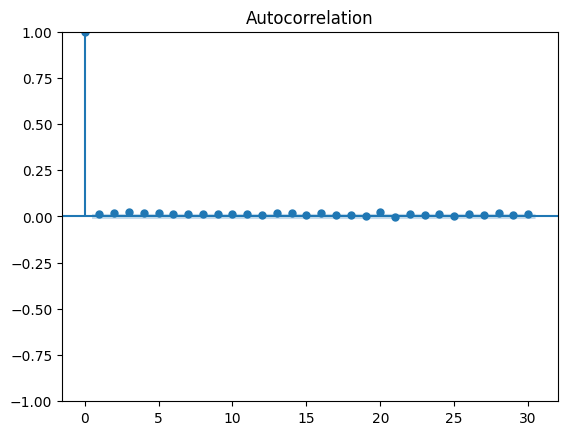

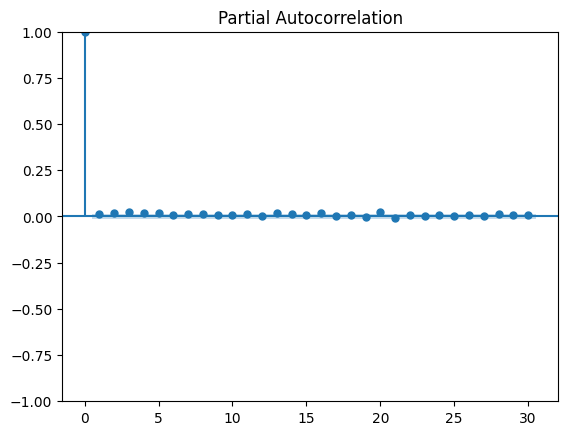

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plot_acf(csv_df['energy_kwh'], lags=30)
plot_pacf(csv_df['energy_kwh'], lags=30)
plt.show()


According to the above plots there is no strong correlation with the past consumption data. So, ARMA and ARIMA model might not suitable for the data.

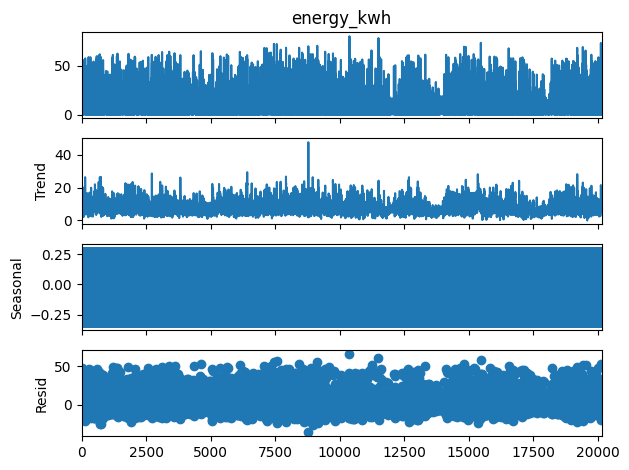

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(csv_df['energy_kwh'], model='additive', period=7)  # Use period=7 for weekly patterns
result.plot()
plt.show()


The above plots do not show any significant seasonality of the energy kwh data. So selecting SARIMA model also not suitable.

In the above context I only evaluate the energy kwh, which is the target variable of the scenario. Since, these three models are univariate model, they only use target varibale for forecasting. These models use to make relationship of the target variable with its own past data.

In the context of the research goal, I will not use these three models to forecast energy consumption.



In [19]:
csv_df['start_date'] = pd.to_datetime(csv_df['start_date'])
csv_df.set_index('start_date', inplace=True)
csv_df.sort_index(inplace=True)

In [20]:
features = ['charging_time_hh_mm_ss', 'longitude', 'tmin', 'tmax', 'tavg', 'coco', 'user_latitude', 'user_longitude', 'length_m', 'duration_s', 'base_duration_s']
target = 'energy_kwh'

In [21]:
def time_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

In [22]:
csv_df['charging_time_seconds'] = csv_df['charging_time_hh_mm_ss'].apply(time_to_seconds)
features.remove('charging_time_hh_mm_ss')
features.append('charging_time_seconds')

In [24]:
# Normalize features
scaler = MinMaxScaler()
csv_df[features] = scaler.fit_transform(csv_df[features])

# Train-test split
train_size = int(len(csv_df) * 0.8)
train, test = csv_df.iloc[:train_size], csv_df.iloc[train_size:]

# Fit SARIMAX model
sarimax_model = SARIMAX(train[target], exog=train[features], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = sarimax_model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [25]:
# Forecasting
forecast = model_fit.forecast(steps=len(test), exog=test[features])

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test[target], forecast)
mse = mean_squared_error(test[target], forecast)
rmse = np.sqrt(mse)

print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


MAE: 2.179347411664195, MSE: 10.829808567914686, RMSE: 3.2908674491560252


In [26]:
r2 = r2_score(test[target], forecast)
print(f'R-squared: {r2}')

R-squared: 0.9038634724696257
